In [1]:
from __future__ import annotations

import copy
import logging
import sys
import time
import warnings

import pandas as pd
import torch
from hydra.utils import instantiate
from omegaconf import DictConfig, ListConfig
from omegaconf import OmegaConf as om
from tqdm import tqdm

from omnivault._types._alias import Missing
from omnivault._types._sentinel import MISSING
from omnivault.core.logger import RichLogger
from omnivault.transformer.config.composer import Composer, DataConfig
from omnivault.transformer.config.constants import MaybeConstant
from omnivault.transformer.config.criterion import CRITERION_REGISTRY
from omnivault.transformer.config.decoder import DecoderConfig
from omnivault.transformer.config.generator import GeneratorConfig
from omnivault.transformer.config.global_ import MaybeGlobal
from omnivault.transformer.config.logger import LoggerConfig
from omnivault.transformer.config.optim import OPTIMIZER_REGISTRY
from omnivault.transformer.config.scheduler import SCHEDULER_REGISTRY, LambdaLRConfig
from omnivault.transformer.config.trainer import TrainerConfig
from omnivault.transformer.core.dataset import AdderDataset, create_loader, split_dataset
from omnivault.transformer.core.optim import apply_weight_decay_to_different_param_groups
from omnivault.transformer.core.scheduler import noam_lr_decay
from omnivault.transformer.core.state import State
from omnivault.transformer.core.tokenizer import AdderTokenizer
from omnivault.transformer.core.trainer import Trainer, TrainerEvent
from omnivault.transformer.core.vocabulary import AdderVocabulary
from omnivault.transformer.decoder.core import GPTDecoder
from omnivault.transformer.utils.config_utils import load_yaml_config, merge_configs
from omnivault.transformer.utils.general_utils import create_directory, download_file, validate_and_cleanup
from omnivault.transformer.utils.reproducibility import seed_all
from omnivault.transformer.utils.visualization import save_plot_history
from omnivault.transformer.config.composer import Composer
from omnivault.transformer.config.criterion import CRITERION_REGISTRY
from omnivault.transformer.config.decoder import (
    AddNormConfig,
    DecoderBlockConfig,
    DecoderConfig,
    MultiHeadedAttentionConfig,
    PositionwiseFeedForwardConfig,
)
from omnivault.transformer.config.generator import GeneratorConfig
from omnivault.transformer.config.optim import OPTIMIZER_REGISTRY
from omnivault.transformer.config.scheduler import SCHEDULER_REGISTRY
from omnivault.transformer.config.trainer import TrainerConfig
from omnivault.transformer.core.dataset import (
    construct_dummy_batch_future_masks,
    construct_dummy_batch_target_padding_masks,
)
from omnivault.transformer.core.state import State
from omnivault.transformer.core.trainer import Trainer, TrainerEvent
from omnivault.transformer.decoder.core import GPTDecoder, GPTDecoderBlock
from omnivault.transformer.modules.attention.core import ScaledDotProductAttention
from omnivault.transformer.utils.general_utils import cleanup
from typing import Any, Dict, List, Optional, Tuple, Union
from torch.utils.data import DataLoader, Dataset
from torch import nn
from functools import partial

In [2]:
seed_all(2024, True, False)

2024

You need to shift input and output in decoder only whereas in encoder only there is no need.

In [3]:
class ReverseDataset(Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [4]:
def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a mask for a single sequence
    mask = torch.ones((seq_len, seq_len), dtype=torch.bool)
    mask = mask.contiguous()
    # broadcast mask from shape (L, L) to (B, L, L)
    masks = mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast mask from shape (B, L, L) to (B, 1, L, L)
    masks = masks.unsqueeze(1)
    return torch.BoolTensor(masks)

In [5]:
def custom_collate_fn(
    batch: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sources, targets = zip(*batch)

    sources = torch.stack(sources)
    targets = torch.stack(targets)

    batch_size, seq_len = targets.size(0), targets.size(1)

    future_masks = construct_dummy_batch_future_masks(batch_size, seq_len)
    target_padding_masks = construct_dummy_batch_target_padding_masks(batch_size, seq_len)

    return sources, targets, future_masks, target_padding_masks

In [6]:
SEQ_LEN = 16
NUM_CATEGORIES = 10

In [7]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True, collate_fn=custom_collate_fn)
val_loader   = DataLoader(dataset(1000), batch_size=128, collate_fn=custom_collate_fn)
test_loader  = DataLoader(dataset(10000), batch_size=128, collate_fn=custom_collate_fn)

In [8]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

for i, (inp_data, labels, future_masks, target_padding_masks) in enumerate(train_loader):
    print("Batch", i)
    print("Input data:", inp_data)
    print("Labels:    ", labels)
    print("Future masks:", future_masks)
    print("Target padding masks:", target_padding_masks)
    break

Input data: tensor([2, 0, 4, 0, 3, 0, 0, 1, 3, 9, 7, 4, 1, 8, 0, 8])
Labels:     tensor([8, 0, 8, 1, 4, 7, 9, 3, 1, 0, 0, 3, 0, 4, 0, 2])
Batch 0
Input data: tensor([[2, 1, 4,  ..., 0, 3, 1],
        [6, 4, 4,  ..., 5, 1, 3],
        [3, 2, 7,  ..., 3, 9, 0],
        ...,
        [2, 7, 4,  ..., 1, 0, 5],
        [1, 6, 4,  ..., 2, 4, 2],
        [0, 8, 6,  ..., 1, 1, 6]])
Labels:     tensor([[1, 3, 0,  ..., 4, 1, 2],
        [3, 1, 5,  ..., 4, 4, 6],
        [0, 9, 3,  ..., 7, 2, 3],
        ...,
        [5, 0, 1,  ..., 4, 7, 2],
        [2, 4, 2,  ..., 4, 6, 1],
        [6, 1, 1,  ..., 6, 8, 0]])
Future masks: tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., Tr

In [9]:
class GPTDecoderReverse(GPTDecoder):
    def __init__(self, config: DecoderConfig) -> None:
        super().__init__(config)
        # fmt: off
        self.d_model       : int           = config.d_model
        self.tok_embed     : nn.Embedding  = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed     : nn.Parameter  = nn.Parameter(torch.zeros(1, config.context_length, config.d_model))
        self.decoder_blocks: nn.ModuleList = nn.ModuleList([GPTDecoderBlock(config) for _ in range(config.num_decoder_blocks)]) # PyTorch did not make ModuleList a proper container, maybe open a PR to make it inherit Generic[T]???

        self.dropout       : nn.Dropout    = nn.Dropout(config.dropout)
        self.layer_norm    : nn.LayerNorm  = nn.LayerNorm(config.d_model)

        self.head = nn.Sequential(
            nn.Linear(config.d_model, config.d_model),
            nn.LayerNorm(config.d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_model, NUM_CATEGORIES)
        )
        # fmt: on

        self.apply(self._init_weights)

        # apply special scaled init to the residual projections, per GPT-2 paper
        for parameter_name, parameter in self.named_parameters():
            if parameter_name.endswith("context_projection.weight"):
                mean = 0.0
                std_dev = 0.02 / torch.sqrt(torch.tensor(2 * config.num_decoder_blocks, dtype=torch.float))
                torch.nn.init.normal_(parameter, mean=mean, std=std_dev)

In [10]:
@torch.no_grad()
def evaluate_on_reverse_dataset(trainer: Trainer, num_batches_to_eval: int | None = None) -> None:
    generator_config = trainer.composer.generator

    model = trainer.model
    model.eval()

    dataloader = trainer.valid_loader  # Assuming you've set your test_loader to use the ReverseDataset
    assert dataloader is not None

    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader, start=1), desc="Evaluating on Reverse Dataset", leave=False)
    for batch_index, (inputs, labels, target_padding_masks, future_masks) in progress_bar:
        inputs, labels = inputs.to(trainer.device), labels.to(trainer.device)
        target_padding_masks = target_padding_masks.to(trainer.device)
        future_masks = future_masks.to(trainer.device)

        logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)
        predictions = logits.argmax(dim=-1)

        total_correct += (predictions == labels).float().sum().item()
        total_samples += labels.numel()

        if num_batches_to_eval and batch_index >= num_batches_to_eval:
            print("Early stopping evaluation.")
            break

    overall_accuracy = total_correct / total_samples
    trainer.logger.info("Overall Accuracy on Reverse Dataset: {:.4f}".format(overall_accuracy))

In [11]:
masked_self_attention_mha_config = MultiHeadedAttentionConfig(
    attention=ScaledDotProductAttention(), d_model=32, H=1, dropout=0.0
)

feed_forward_config = PositionwiseFeedForwardConfig(
    d_model=32, d_ff=32 * 2, activation=nn.GELU(approximate="tanh"), dropout=0.0, bias=True
)

add_norm_config_1 = AddNormConfig(feature_dim=32, dropout=0.0)
add_norm_config_2 = AddNormConfig(feature_dim=32, dropout=0.0)

# Create DecoderBlockConfig
decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

# Create the overall DecoderConfig
model_config = DecoderConfig(
    d_model=32,
    vocab_size=NUM_CATEGORIES,
    context_length=SEQ_LEN,
    num_decoder_blocks=1,
    dropout=0.0,
    decoder_block=decoder_block_config,
)
GRADIENT_ACCUMULATION_STEPS = 1

optimizer_config_cls = OPTIMIZER_REGISTRY["torch.optim.Adam"]
optimizer_pydantic_config = optimizer_config_cls(name="torch.optim.Adam", lr=4e-3)

criterion_config_cls = CRITERION_REGISTRY["torch.nn.CrossEntropyLoss"]
criterion_pydantic_config = criterion_config_cls(name="torch.nn.CrossEntropyLoss")

scheduler_config_cls = SCHEDULER_REGISTRY["torch.optim.lr_scheduler.CosineAnnealingLR"]
scheduler_pydantic_config = scheduler_config_cls(name="torch.optim.lr_scheduler.CosineAnnealingLR", T_max=10)

trainer_config = TrainerConfig(
    device="cpu",
    max_epochs=10,
    eval_every_n_steps=10000,
    log_every_n_steps=10000,
    # use_amp=True,
    autocast_config={"enabled": False}, # , "dtype": torch.float16, "cache_enabled": True},
    # scaler_config={
    #     "enabled": True,
    #     "init_scale": 2.0**16,
    #     "growth_factor": 2.0,
    #     "backoff_factor": 0.5,
    #     "growth_interval": 2000,
    # },
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    clip_grad_norm={"max_norm": 1.0, "norm_type": 2.0, "error_if_nonfinite": False, "foreach": None},
    apply_weight_decay_to_different_param_groups=False,
    step_scheduler_on_batch_or_epoch="epoch",
    save_dir="./data/reversal/checkpoints",
    save_every_epoch=False,
    save_best_only=True,
    monitor="valid_this_epoch_average_loss",
    mode="min",
)

generator_config = GeneratorConfig(temperature=1.0, max_tokens=SEQ_LEN, greedy=False, top_k=10, top_p=None)

In [12]:
composer = Composer(
    model=model_config,
    optimizer=optimizer_pydantic_config,
    criterion=criterion_pydantic_config,
    scheduler=scheduler_pydantic_config,
    trainer=trainer_config,
    generator=generator_config,
)

In [13]:
model = GPTDecoderReverse(model_config).to(composer.trainer.device)
optimizer = optimizer_pydantic_config.build(params=model.parameters())
criterion = criterion_pydantic_config.create_instance()

composer.scheduler = scheduler_pydantic_config
scheduler = scheduler_pydantic_config.build(optimizer=optimizer)

#composer.pretty_print()


state = State(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # vocabulary=vocabulary,
    # tokenizer=tokenizer,
)

device = composer.trainer.device
trainer = Trainer(
    state=state,
    composer=composer,
    logger=None,
    device=device,  # type: ignore[arg-type]
)

trainer.add_callback(
    TrainerEvent.ON_VALID_EPOCH_END.value,
    lambda trainer: evaluate_on_reverse_dataset(trainer, num_batches_to_eval=None),
)

In [14]:
_trained_state = trainer.fit(train_loader=train_loader, valid_loader=val_loader)

2024-03-14 17:33:21,505 - root - INFO - Initial learning rate: 0.004
2024-03-14 17:33:21,506 - root - INFO - Total Parameters: 10762, Trainable Parameters: 10762
2024-03-14 17:33:21,507 - root - INFO - ====================================================== Starting Train Epoch: 1/10 ======================================================
2024-03-14 17:33:26,197 - root - INFO - Total Samples:                   50000                                                                                                  
2024-03-14 17:33:26,198 - root - INFO - Total Batches:                   390
2024-03-14 17:33:26,198 - root - INFO - Average Epoch Train Loss:        2.15890
2024-03-14 17:33:26,198 - root - INFO - Average Epoch Train Perplexity:  8.66164
2024-03-14 17:33:26,198 - root - INFO - 

2024-03-14 17:33:26,199 - root - INFO - ====================================================== Starting Valid Epoch: 1/10 ======================================================
2024-03-14 17:33:26,253 - 

on importance of LR. lol.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

last_decoder_block = _trained_state.model.decoder_blocks[-1]

In [16]:
last_decoder_block

GPTDecoderBlock(
  (masked_self_attention_mha): MultiHeadedAttention(
    (W_Q): Linear(in_features=32, out_features=32, bias=False)
    (W_K): Linear(in_features=32, out_features=32, bias=False)
    (W_V): Linear(in_features=32, out_features=32, bias=False)
    (W_O): Linear(in_features=32, out_features=32, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (ffn): ModuleDict(
      (context_fc): Linear(in_features=32, out_features=64, bias=True)
      (activation): GELU(approximate='tanh')
      (context_projection): Linear(in_features=64, out_features=32, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (add_norm_1): AddNorm(
    (dropout): Dropout(p=0.0, inplace=False)
    (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (add_norm_2): AddNorm(
    (dropout): Dropout(p=0.0, inplace=False)

In [17]:
masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

# Number of heads
num_heads = attention_weights.size(1)

print("Context vector shape:", context_vector.size())
print("Attention weights shape:", attention_weights.size())
print("Number of heads:", num_heads)

Context vector shape: torch.Size([104, 1, 16, 32])
Attention weights shape: torch.Size([104, 1, 16, 16])
Number of heads: 1


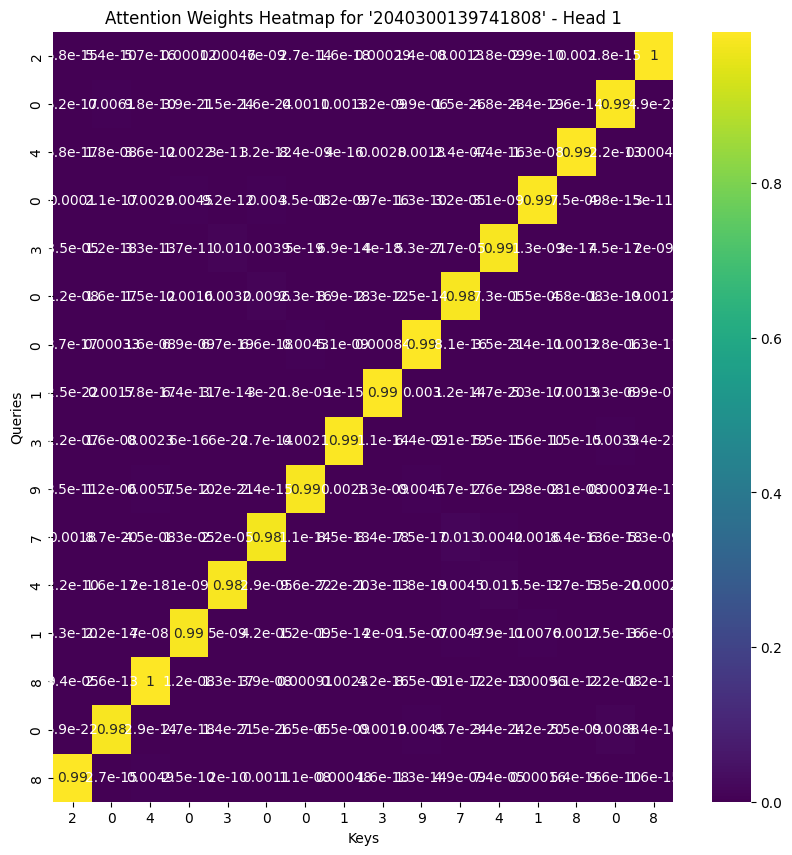

In [19]:
# Input data: tensor([2, 0, 4, 0, 3, 0, 0, 1, 3, 9, 7, 4, 1, 8, 0, 8])
# Labels:     tensor([8, 0, 8, 1, 4, 7, 9, 3, 1, 0, 0, 3, 0, 4, 0, 2])

# Labels for each character in the sequence, including BOS
input = "2040300139741808"
label = input[::-1]

# Loop over each head and plot its heatmap
for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    # Extract attention weights for the last sample in the last batch for this head
    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=input, yticklabels=input)
    plt.title(f"Attention Weights Heatmap for '{input}' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


The heatmap diagonal is correct because in the above image, we can
treat it as a 2 by 2 matrix, where the first row is the first token from query,
interacting with every other token as keys. So if first token is 2 and last token is 8,
then it should be matching each other because of the "reversal".